In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
from scipy import signal
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

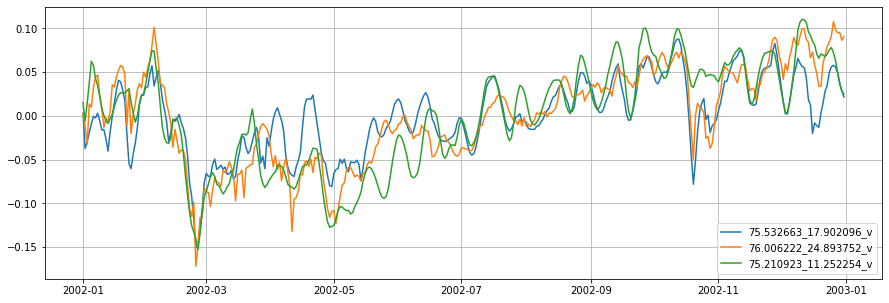

In [3]:
df_nemo=pd.read_csv('./timelines_data/formed_timelines_2002/2002_spitz_nemo.csv', sep=';')
df_nemo['dates'] =  pd.to_datetime(df_nemo['dates'], format='%Y-%m-%d')
df_nemo['75.532663_17.902096_v']=df_nemo['75.532663_17.902096']-np.mean(df_nemo['75.532663_17.902096'])
df_nemo['76.006222_24.893752_v']=df_nemo['76.006222_24.893752']-np.mean(df_nemo['76.006222_24.893752'])
df_nemo['75.210923_11.252254_v']=df_nemo['75.210923_11.252254']-np.mean(df_nemo['75.210923_11.252254'])

plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(df_nemo['dates'], df_nemo['75.532663_17.902096_v'], label='75.532663_17.902096_v')
plt.plot(df_nemo['dates'], df_nemo['76.006222_24.893752_v'], label='76.006222_24.893752_v')
plt.plot(df_nemo['dates'], df_nemo['75.210923_11.252254_v'], label='75.210923_11.252254_v')
plt.legend()
plt.grid()
plt.show()

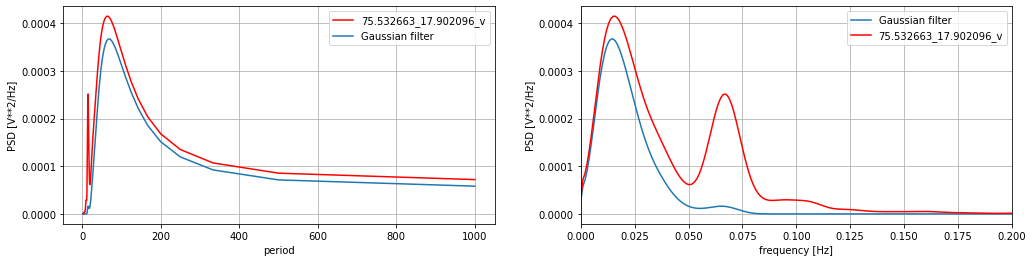

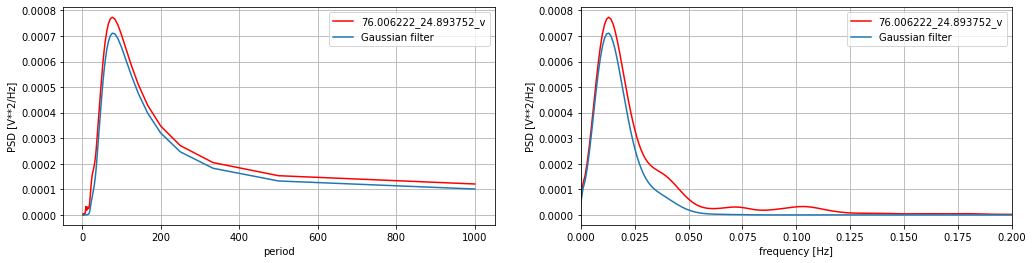

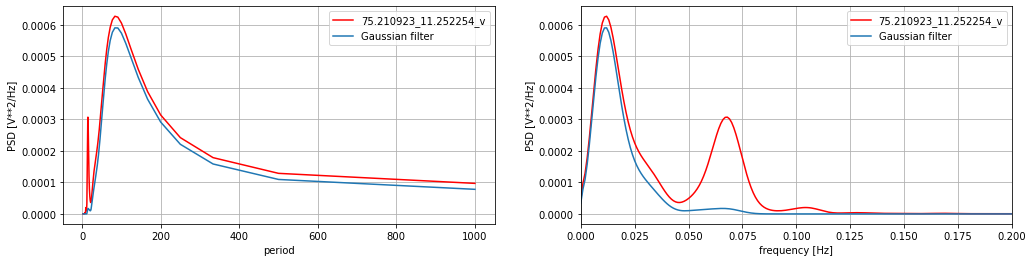

In [4]:
plt.rcParams['figure.figsize'] = [17, 4]
windows_size=14
gauss_sd=5
window = signal.gaussian(windows_size, gauss_sd)

output_gauss=signal.convolve(df_nemo['75.532663_17.902096_v'], window/window.sum(), mode='same')
f, Pxx_den = signal.welch(output_gauss, fs=1, scaling='spectrum', nfft = 1000, nperseg=100)
b_f, b_Pxx_den = signal.welch(df_nemo['75.532663_17.902096_v'], fs=1, scaling='spectrum', nfft = 1000, nperseg=100)

plt.subplot(1, 2, 1)
plt.plot(1/b_f, b_Pxx_den, c='r', label='75.532663_17.902096_v')
plt.plot(1/f, Pxx_den, label='Gaussian filter')
plt.grid()
plt.legend()
plt.xlabel('period')
plt.ylabel('PSD [V**2/Hz]')

plt.subplot(1, 2, 2)
plt.plot(f, Pxx_den, label='Gaussian filter' )
plt.plot(b_f, b_Pxx_den, c='r', label='75.532663_17.902096_v')
plt.xlim(0, 0.2)
plt.grid()
plt.legend()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()
df_nemo['75.532663_17.902096_v']=output_gauss

##########################################
output_gauss=signal.convolve(df_nemo['76.006222_24.893752_v'], window/window.sum(), mode='same')
f, Pxx_den = signal.welch(output_gauss, fs=1, scaling='spectrum', nfft = 1000, nperseg=100)
b_f, b_Pxx_den = signal.welch(df_nemo['76.006222_24.893752_v'], fs=1, scaling='spectrum', nfft = 1000, nperseg=100)

plt.subplot(1, 2, 1)
plt.plot(1/b_f, b_Pxx_den, c='r', label='76.006222_24.893752_v')
plt.plot(1/f, Pxx_den, label='Gaussian filter')
plt.grid()
plt.legend()
plt.xlabel('period')
plt.ylabel('PSD [V**2/Hz]')

plt.subplot(1, 2, 2)
plt.plot(b_f, b_Pxx_den, c='r', label='76.006222_24.893752_v')
plt.plot(f, Pxx_den, label='Gaussian filter' )
plt.xlim(0, 0.2)
plt.grid()
plt.legend()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()
df_nemo['76.006222_24.893752_v']=output_gauss

##########################################
output_gauss=signal.convolve(df_nemo['75.210923_11.252254_v'], window/window.sum(), mode='same')
f, Pxx_den = signal.welch(output_gauss, fs=1, scaling='spectrum', nfft = 1000, nperseg=100)
b_f, b_Pxx_den = signal.welch(df_nemo['75.210923_11.252254_v'], fs=1, scaling='spectrum', nfft = 1000, nperseg=100)

plt.subplot(1, 2, 1)
plt.plot(1/b_f, b_Pxx_den, c='r', label='75.210923_11.252254_v')
plt.plot(1/f, Pxx_den, label='Gaussian filter')
plt.grid()
plt.legend()
plt.xlabel('period')
plt.ylabel('PSD [V**2/Hz]')

plt.subplot(1, 2, 2)
plt.plot(b_f, b_Pxx_den, c='r', label='75.210923_11.252254_v')
plt.plot(f, Pxx_den, label='Gaussian filter' )
plt.xlim(0, 0.2)
plt.grid()
plt.legend()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()
df_nemo['75.210923_11.252254_v']=output_gauss

***Вот NEMO выглядит адекватно. Ярко выраженная 14-дневная периодичность, неразмазанный пик на 70-80 днях***

Но так как данные реанализа мы считаем эталонными, сглаживаем 14 дней 

## Раскладываем временные ряды NEMO на составляющие

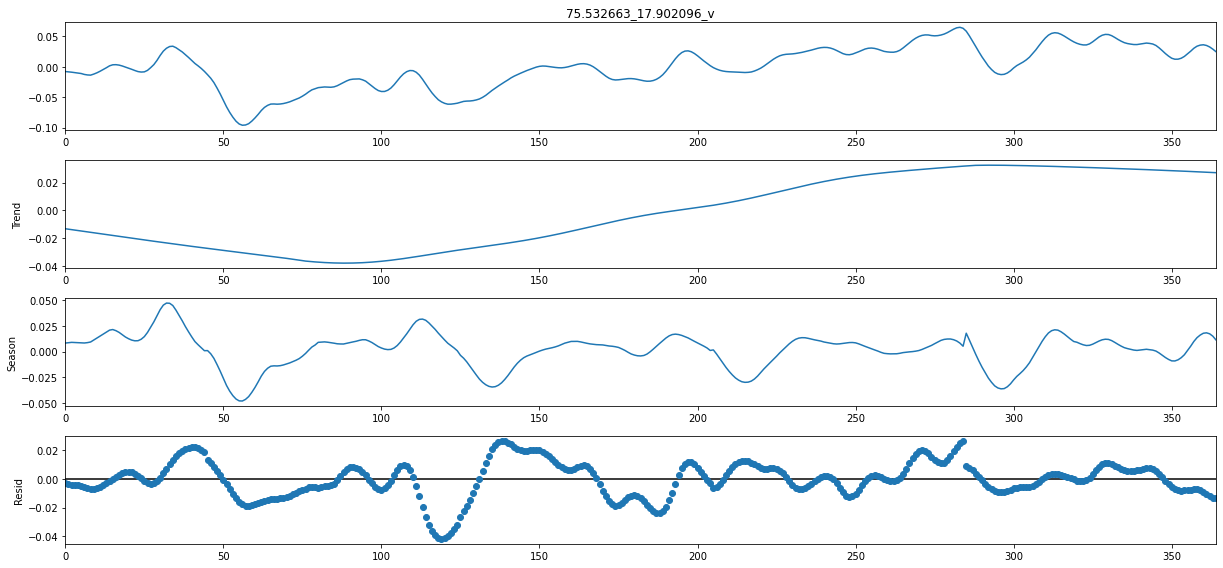

In [5]:
plt.rcParams['figure.figsize'] = [17, 8]
stl = STL(df_nemo['75.532663_17.902096_v'], period=80)
res = stl.fit()
fig = res.plot()

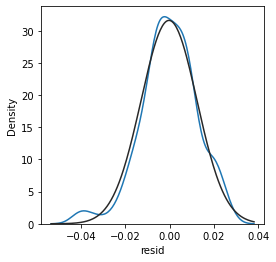

KstestResult(statistic=0.05500371961537298, pvalue=0.21152685356485945)


In [6]:
plt.rcParams['figure.figsize'] = [4, 4]
sns.distplot(res.resid, fit=norm, hist=False)
plt.show()
params = norm.fit(res.resid)
ks = kstest(res.resid, 'norm', params, N=1000)
print(ks)
if (ks[1]>=0.07):
    ds_no_resid=df_nemo['75.532663_17.902096_v']-res.resid
    df_nemo['75.532663_17.902096_no_res']=ds_no_resid

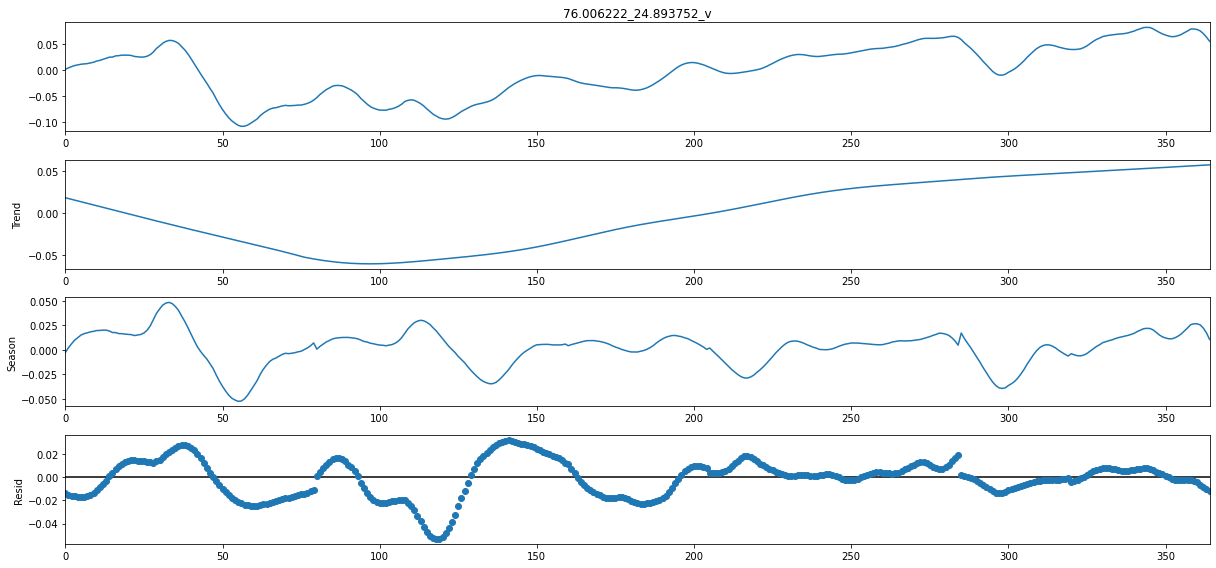

In [7]:
plt.rcParams['figure.figsize'] = [17, 8]
stl = STL(df_nemo['76.006222_24.893752_v'], period=80)
res = stl.fit()
fig = res.plot()

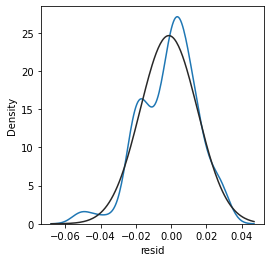

KstestResult(statistic=0.08065457099601364, pvalue=0.01635094478568505)


In [8]:
plt.rcParams['figure.figsize'] = [4, 4]
sns.distplot(res.resid, fit=norm, hist=False)
plt.show()
params = norm.fit(res.resid)
ks = kstest(res.resid, 'norm', params, N=1000)
print(ks)
if (ks[1]>=0.07):
    ds_no_resid=df_nemo['76.006222_24.893752_v']-res.resid
    df_nemo['76.006222_24.893752_no_res']=ds_no_resid

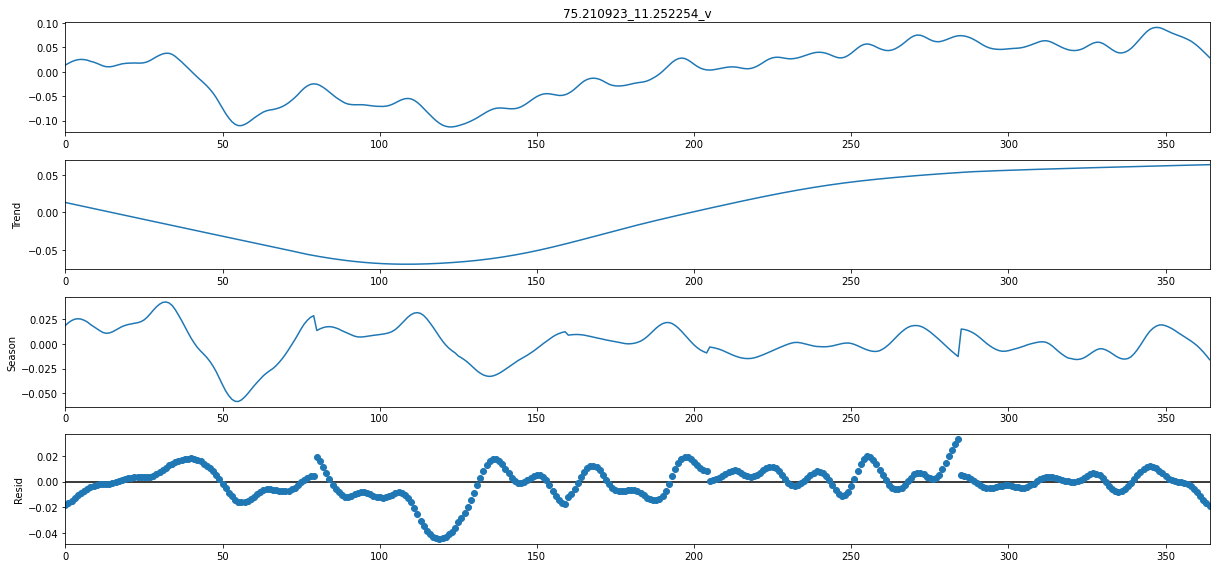

In [9]:
plt.rcParams['figure.figsize'] = [17, 8]
stl = STL(df_nemo['75.210923_11.252254_v'], period=80)
res = stl.fit()
fig = res.plot()

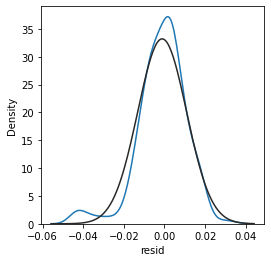

KstestResult(statistic=0.06556222295383099, pvalue=0.08294317568175458)


In [10]:
plt.rcParams['figure.figsize'] = [4, 4]
sns.distplot(res.resid, fit=norm, hist=False)
plt.show()
params = norm.fit(res.resid)
ks = kstest(res.resid, 'norm', params, N=1000)
print(ks)
if (ks[1]>=0.07):
    ds_no_resid=df_nemo['75.210923_11.252254_v']-res.resid
    df_nemo['75.210923_11.252254_no_res']=ds_no_resid

## Считаем корреляции между реанализом и сглаженными данными NEMO 

In [11]:
import scipy.stats

In [13]:
df_rean=pd.read_csv('./timelines_data/formed_timelines_2002/2002_spitz_reanalysis.csv', sep=';')
df_rean['dates'] =  pd.to_datetime(df_rean['dates'], format='%Y-%m-%d')
df_rean['75.532663_17.902096_v']=df_rean['75.532663_17.902096']-np.mean(df_rean['75.532663_17.902096'])
df_rean['76.006222_24.893752_v']=df_rean['76.006222_24.893752']-np.mean(df_rean['76.006222_24.893752'])
df_rean['75.210923_11.252254_v']=df_rean['75.210923_11.252254']-np.mean(df_rean['75.210923_11.252254'])

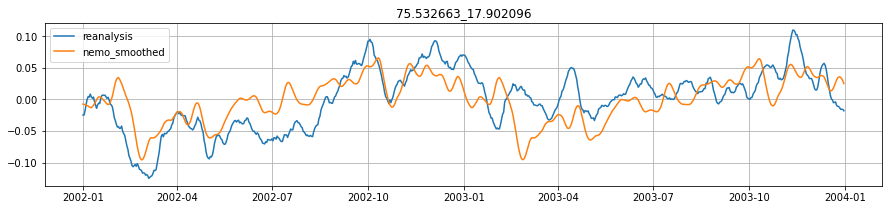

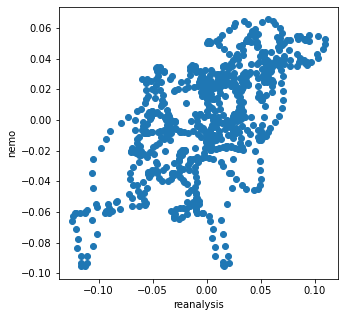

(0.6022925921798983, 2.864723504419217e-73)
SpearmanrResult(correlation=0.5875920924363534, pvalue=5.604281357624809e-69)
KendalltauResult(correlation=0.4154234172098931, pvalue=2.864739952626914e-63)


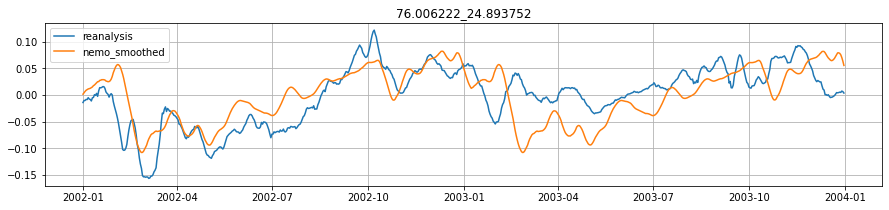

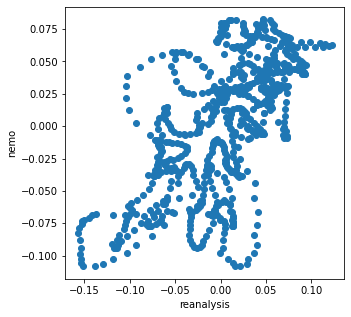

(0.6163865404298587, 1.3419151420728382e-77)
SpearmanrResult(correlation=0.6210498671939091, pvalue=4.430043291734323e-79)
KendalltauResult(correlation=0.43686904290010864, pvalue=8.862535399595244e-70)


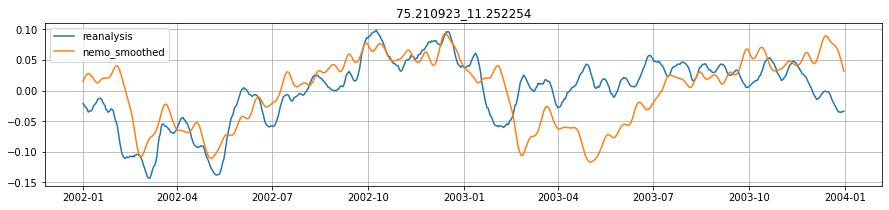

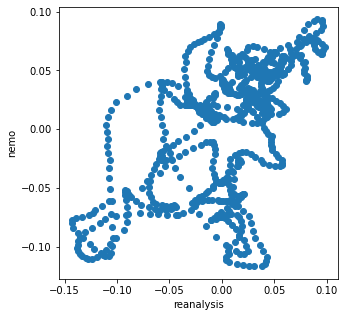

(0.555073075132607, 3.15808286572648e-60)
SpearmanrResult(correlation=0.5362533718472324, pvalue=1.3758436311083064e-55)
KendalltauResult(correlation=0.37786559835278954, pvalue=1.1628416683899577e-52)


In [87]:
x=df_rean['75.532663_17.902096_v']
y=df_nemo['75.532663_17.902096_v']

plt.rcParams['figure.figsize'] = [15, 3]
plt.plot(df_rean['dates'], x, label='reanalysis')
plt.plot(df_nemo['dates'], y, label='nemo_smoothed')
plt.title('75.532663_17.902096')
plt.legend()
plt.grid()
plt.show()

plt.rcParams['figure.figsize'] = [5, 5]
plt.scatter(x, y)
plt.xlabel('reanalysis')
plt.ylabel('nemo')
plt.show()
print(scipy.stats.pearsonr(x, y))    # Pearson's r
print(scipy.stats.spearmanr(x, y))   # Spearman's rho
print(scipy.stats.kendalltau(x, y))  # Kendall's tau

x=df_rean['76.006222_24.893752_v']
y=df_nemo['76.006222_24.893752_v']

plt.rcParams['figure.figsize'] = [15, 3]
plt.plot(df_rean['dates'], x, label='reanalysis')
plt.plot(df_nemo['dates'], y, label='nemo_smoothed')
plt.title('76.006222_24.893752')
plt.legend()
plt.grid()
plt.show()

plt.rcParams['figure.figsize'] = [5, 5]
plt.scatter(x, y)
plt.xlabel('reanalysis')
plt.ylabel('nemo')
plt.show()
print(scipy.stats.pearsonr(x, y))    # Pearson's r
print(scipy.stats.spearmanr(x, y))   # Spearman's rho
print(scipy.stats.kendalltau(x, y))  # Kendall's tau

x=df_rean['75.210923_11.252254_v']
y=df_nemo['75.210923_11.252254_v']

plt.rcParams['figure.figsize'] = [15, 3]
plt.plot(df_rean['dates'], x, label='reanalysis')
plt.plot(df_nemo['dates'], y, label='nemo_smoothed')
plt.title('75.210923_11.252254')
plt.legend()
plt.grid()
plt.show()

plt.rcParams['figure.figsize'] = [5, 5]
plt.scatter(x, y)
plt.xlabel('reanalysis')
plt.ylabel('nemo')
plt.show()
print(scipy.stats.pearsonr(x, y))    # Pearson's r
print(scipy.stats.spearmanr(x, y))   # Spearman's rho
print(scipy.stats.kendalltau(x, y))  # Kendall's tau



***Корреляция положительная, но не сильная, а вообще графики созависимости выглядят странно... В общем использовать NEMO как экзогенный фактор в таком виде бессмысленно***

***Еще кажется, что такое сильное расхождение как раз из-за различия в тренде, сравним и проверим:***

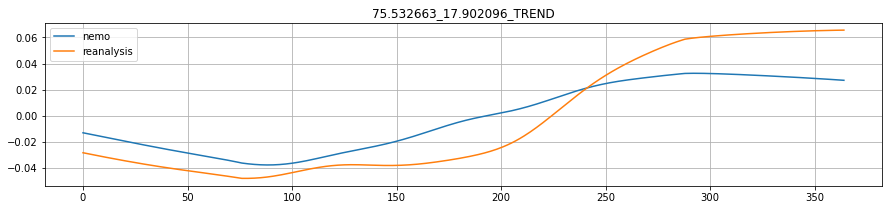

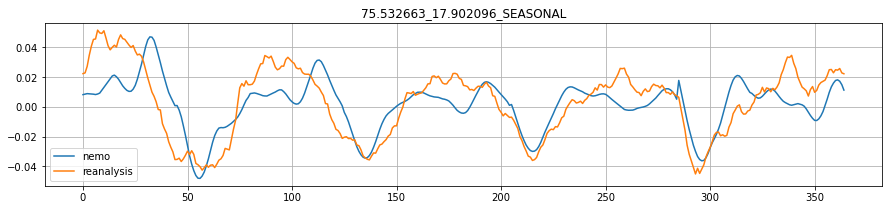

In [17]:
stl_n = STL(df_nemo['75.532663_17.902096_v'], period=80)
res_n = stl_n.fit()
stl_r = STL(df_rean['75.532663_17.902096_v'], period=80)
res_r = stl_r.fit()

plt.rcParams['figure.figsize'] = [15, 3]
plt.plot(res_n.trend, label='nemo')
plt.plot(res_r.trend, label='reanalysis')
plt.legend()
plt.title('75.532663_17.902096_TREND')
plt.grid()
plt.show()
#ОСТАТКИ УЧИТЫВАЕМ
plt.plot(res_n.seasonal, label='nemo')
plt.plot(res_r.seasonal, label='reanalysis')
plt.legend()
plt.title('75.532663_17.902096_SEASONAL')
plt.grid()
plt.show()

***Начало хорошее, но в конце вообще не бьется***

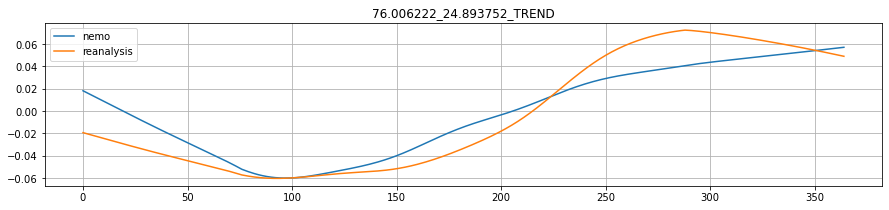

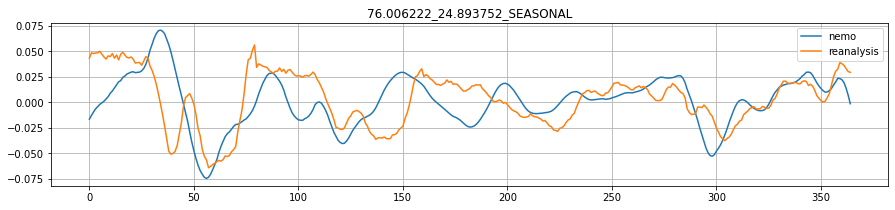

In [19]:
stl_n = STL(df_nemo['76.006222_24.893752_v'], period=80)
res_n = stl_n.fit()
stl_r = STL(df_rean['76.006222_24.893752_v'], period=80)
res_r = stl_r.fit()

plt.rcParams['figure.figsize'] = [15, 3]
plt.plot(res_n.trend, label='nemo')
plt.plot(res_r.trend, label='reanalysis')
plt.legend()
plt.title('76.006222_24.893752_TREND')
plt.grid()
plt.show()
#ОСТАТКИ УЧИТЫВАЕМ
plt.plot(res_n.seasonal+res_n.resid, label='nemo')
plt.plot(res_r.seasonal, label='reanalysis')
plt.legend()
plt.title('76.006222_24.893752_SEASONAL')
plt.grid()
plt.show()

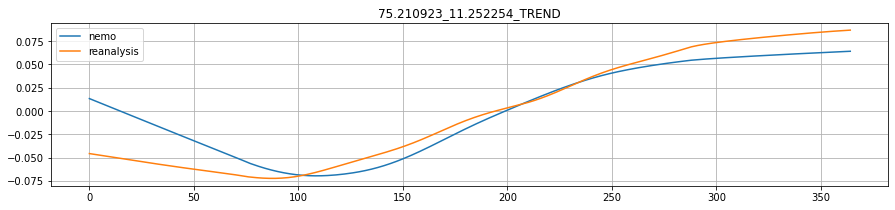

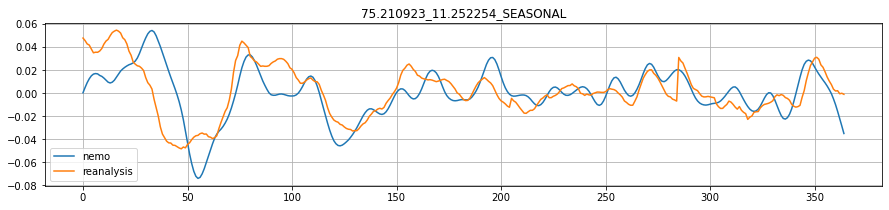

In [20]:
stl_n = STL(df_nemo['75.210923_11.252254_v'], period=80)
res_n = stl_n.fit()
stl_r = STL(df_rean['75.210923_11.252254_v'], period=80)
res_r = stl_r.fit()

plt.rcParams['figure.figsize'] = [15, 3]
plt.plot(res_n.trend, label='nemo')
plt.plot(res_r.trend, label='reanalysis')
plt.legend()
plt.title('75.210923_11.252254_TREND')
plt.grid()
plt.show()
#ОСТАТКИ УЧИТЫВАЕМ
plt.plot(res_n.seasonal+res_n.resid, label='nemo')
plt.plot(res_r.seasonal, label='reanalysis')
plt.legend()
plt.title('75.210923_11.252254_SEASONAL')
plt.grid()
plt.show()